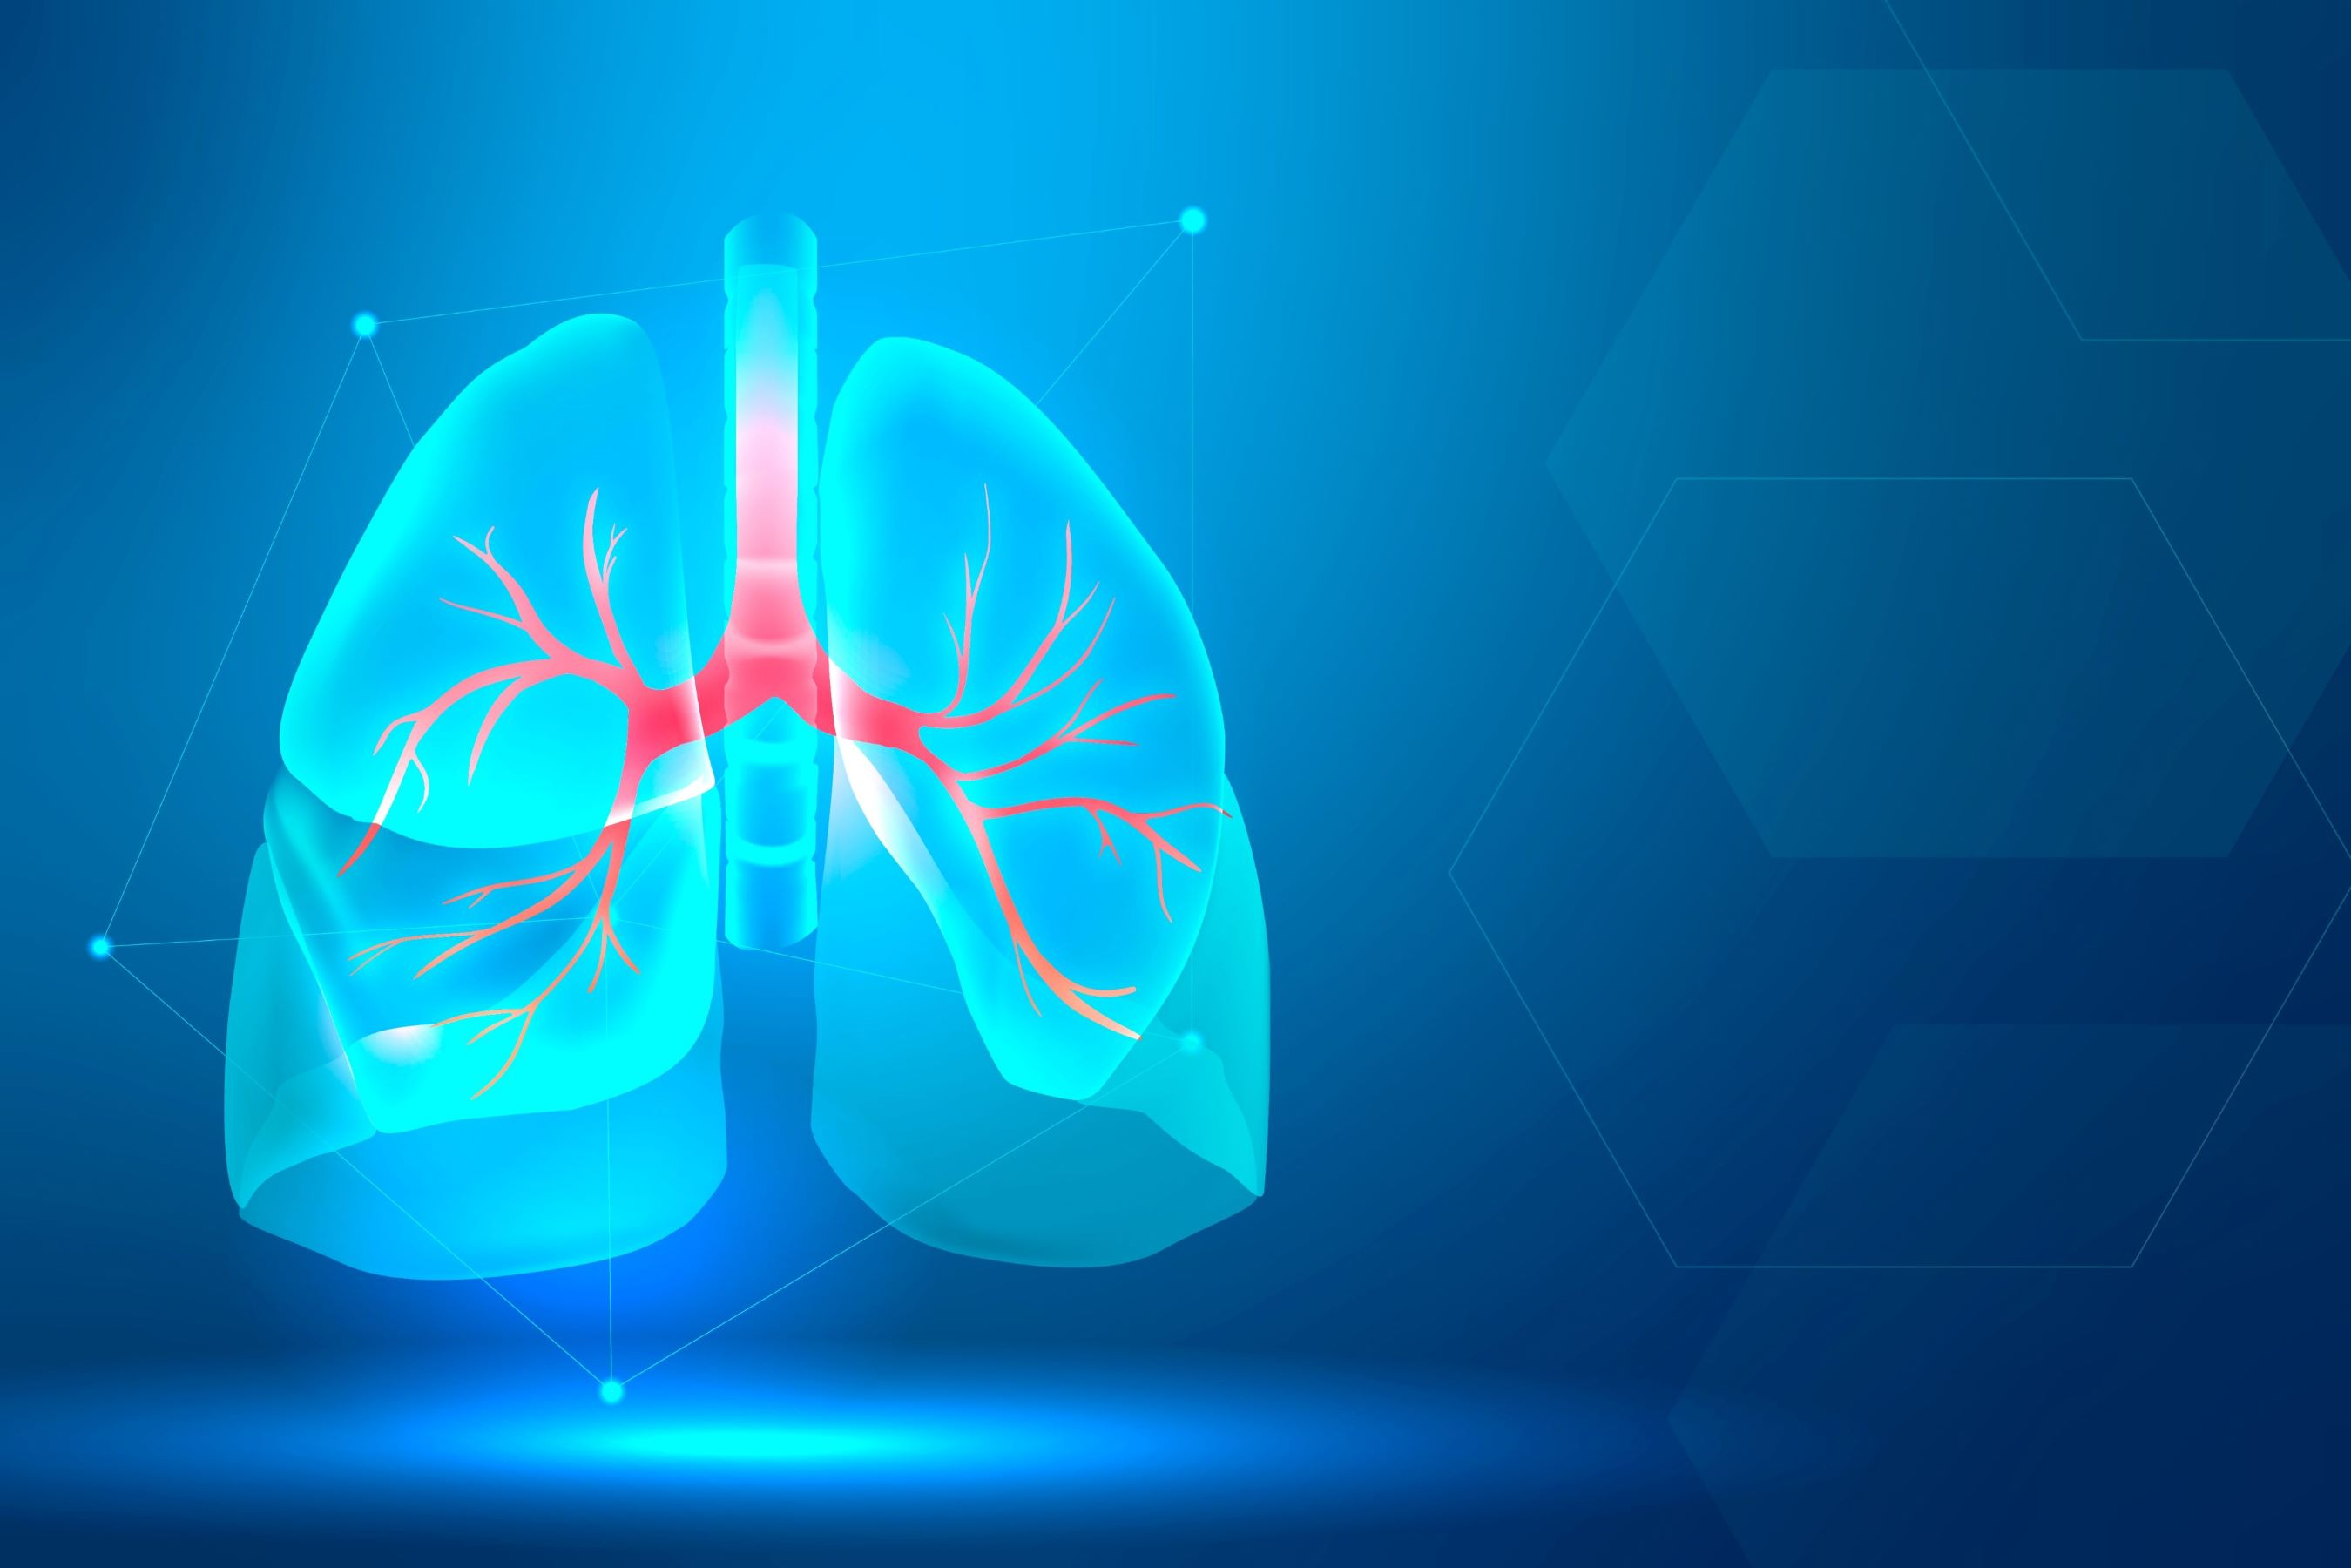<a href="https://www.freepik.com/free-photo/lung-banner-respiratory-system-smart-healthcare_15606697.htm#&position=0&from_view=search&track=ais&uuid=3b57e105-1583-49d8-a5a7-4af603958964">Image by rawpixel.com</a> on Freepik

# Chest X-ray Classification
### Image Classification Modeling to Detect Pneumonia in Pediatric Patients  
Elimelech Berlin  
September 2023

***
## Overview
This project aims to construct an image classification model capable of accurately diagnosing pneumonia in pediatric patients, from chest X-ray images. Utilizing an iterative aproach, a convolutional neural network capable of identifying 91% of pneumonial scans present in the test group of the images, emerges as the most performant model.

***
## Context
Pneumonia can be detected by visual inspection of chest X-ray scans - scans of those with the disease exhibit abnormal opacification in the lung cavity, while imagery of healthy lungs is clear.  
A model capable of detecting such abnormality, & classifying chest X-rays as either normal or displaying evidence of pneumonia, would enable medical professionals to delegate reading such scans to an automated system, thereby attaining greater efficiency in healthcare. Additionaly, such a tool may prove useful in detecting disease in patients whose scan abnormality is slight enough to be overlooked by even trained medical technicians.

***
## Data  
The images used for this report come from Kaggle's [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) dataset. The images are chest X-ray scans of pediatric patients between ages 1 and 5 years old obtained from routine patient scans at Guangzhou Women and Children’s Medical Center, Guangzhou (China).  
The nearly 6K images are classified into two categories: Normal or Pneumonia.  
As provided by Kaggle, the images are divided into three subsets:
* train - 5,216 images
* validate - 16 images
* test - 631 images

***
## Preprocessing
In this section we explore the number of images present in each data subset & adjust the groups accordingly.  
Also, after we load the images, we have a look at the number of scans in each class in the training subset; and lastly, display a few sample images to gain a better understanding of the classification task at hand.

First, execute all imports:

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, regularizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import pandas as pd
import random
import os
import shutil
import tensorflow as tf
import json

Before loading the images, let's have a look at the size of the train/validate/test split:

In [2]:
# this cell will only show the original files the first time the notebook is run
train_num = len(os.listdir('data/chest_xray/train/PNEUMONIA')) + len(os.listdir('data/chest_xray/train/NORMAL'))
print('total train samples:', train_num)

val_num = len(os.listdir('data/chest_xray/val/PNEUMONIA')) + len(os.listdir('data/chest_xray/val/NORMAL')) 
print('total validation samples:', val_num)

test_num = len(os.listdir('data/chest_xray/test/PNEUMONIA')) + len(os.listdir('data/chest_xray/test/NORMAL'))
print('total test samples:', val_num)

# the original output is:
# total train samples: 5216
# total validation samples: 16

total train samples: 4184
total validation samples: 1048
total test samples: 1048


> We see very few samples in the validation set. Let's correct this by moving enough images from the training data folders to the validation folders, to make the split equal to about 80/20.

In [3]:
np.random.seed(24)

# the while loop checks the number of validation images & if it's less than 1047 (20% of images) tries to move file from training folder
while len(os.listdir('data/chest_xray/val/NORMAL')) + len(os.listdir('data/chest_xray/val/PNEUMONIA')) < (train_num + val_num) * .2:
                                                         try:
                                                             for i in np.random.choice(1047, 1047):
                                                                 directory = random.choice(['NORMAL', 'PNEUMONIA'])
                                                                 filename = os.listdir('data/chest_xray/train/{}'.format(directory))[i]
                                                                 shutil.move('data/chest_xray/train/{}/{}'.format(directory, filename), 'data/chest_xray/val/{}'.format(directory))
                                                         except:
                                                             pass

Now, check the updated file sizes:

In [4]:
train_num = len(os.listdir('data/chest_xray/train/PNEUMONIA')) + len(os.listdir('data/chest_xray/train/NORMAL'))
print('total train samples:', train_num)

val_num = len(os.listdir('data/chest_xray/val/PNEUMONIA')) + len(os.listdir('data/chest_xray/val/NORMAL')) 
print('total validation samples:', val_num)

total train samples: 4184
total validation samples: 1048


With the file sizes readjusted, let's proceed with loading the images with ImageDataGenerator:

In [5]:
# define filepaths for each data subset
train_dir = 'data/chest_xray/train'
validation_dir = 'data/chest_xray/val'
test_dir = 'data/chest_xray/test'

In [6]:
# instantiate ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# use ImageDataGenerators to load images as collections of matrices
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    seed = 12,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(validation_dir,
                                                target_size=(150, 150),
                                                batch_size=20,
                                                seed = 12,
                                                class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  seed = 12,
                                                  class_mode='binary')

Found 4184 images belonging to 2 classes.
Found 1048 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


View label mapping:

In [8]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

With the imges loaded, let's visualize the class distribution of training data:

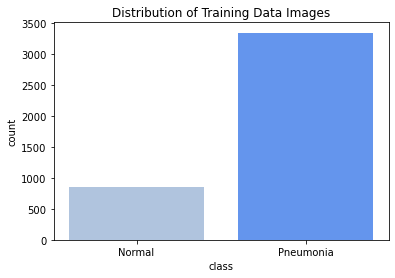

In [9]:
# create array of classes
tr_dist_counts = np.bincount(train_generator.classes)


# visualize distribution of training data
plt.bar(train_generator.class_indices.values(), tr_dist_counts, tick_label = [x.capitalize() for x in train_generator.class_indices.keys()], color = ['lightsteelblue', 'cornflowerblue'])
plt.xlabel('class')
plt.ylabel('count')
plt.title('Distribution of Training Data Images');

# save plot
# plt.savefig('images/train_class_dist.png', bbox_inches='tight', pad_inches=.2)

> There is strong class imbalance present in the training dataset. This may need to be accounted for in training the model.

To get a sense of the image classification task at hand, we display several examples of normal scans & a few examples of pnuemonial scans. To do so, loop through a batch of images, sort them by their labels, & display 4 of each:

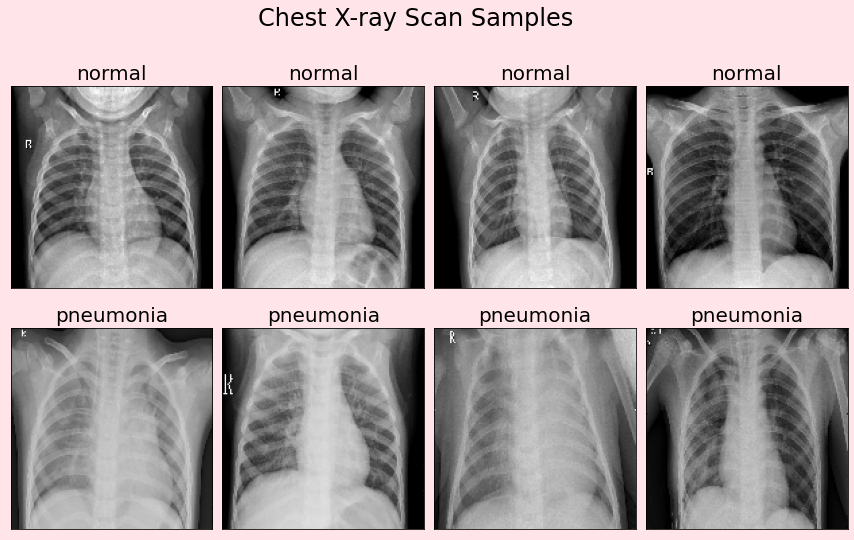

In [10]:
# set a variable for images & labels of a batch
img, label = train_generator[1]

# set the plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
fig.patch.set_facecolor('pink')
fig.patch.set_alpha(0.4)
fig.suptitle('Chest X-ray Scan Samples', fontsize=24, y =.92)

x = 0
y = 0

# loop through the batch
for i in range(20):

# sort by label & plot accordingly
    if label[i] == 0 and x < 4:
        axes[0, x].imshow(img[i])
        axes[0, x].set_title('normal', fontsize=20)
        axes[0, x].get_xaxis().set_visible(False)
        axes[0, x].get_yaxis().set_visible(False)
        x += 1
        
    if label[i] == 1 and y < 4:
        axes[1, y].imshow(img[i])
        axes[1, y].set_title('pneumonia', fontsize=20)
        axes[1, y].get_xaxis().set_visible(False)
        axes[1, y].get_yaxis().set_visible(False)
        y += 1


plt.subplots_adjust(wspace=0.05, hspace=-.2);
        
# save the images       
# plt.savefig('images/scan_samples', facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=.2)

> Note the increased opacification (white fuzziness) of the lung cavities visible in the images labeled as pneumonia. That opacification is the abnormality present in the scans that any model constructed to sort these images must detect.

***
## Modeling
This project utilizes convolutional neural networks in an effort to build a model capable of our image classification task.  
In this section we begin by building a simple baseline convolutional neural network model, & iteratively increase model complexity in an effort to improve model performance.  
After three models are built (each progressively more complex), a final model, based on the earlier model found to be the most performant, is constructed, with several hyperparameters adjusted to tune model performance.

For each model constructed, the following steps are followed:
* instantiate a model & add layers
* compile
* train
* save
* save model history
* (load model/model history)
* view model summary
* visualize training performance (train vs. validation across epochs)
* generate predictions on test set
* assess test predictions with a classification report & confusion matrix
* evaluate performance

### Baseline Model
Construct a basic convolutional neural network with minimum layers:
* 1 convolutional layer (followed by pooling layer)
* flattening layer 
* 1 dense layer

In [11]:
# build a baseline cnn
random.seed(583)
np.random.seed(583)
tf.random.set_seed(583)

baseline_model = models.Sequential()

baseline_model.add(layers.Conv2D(16, kernel_size=(3, 3), input_shape=(150, 150, 3), activation='relu'))

baseline_model.add(layers.MaxPooling2D())

baseline_model.add(layers.Flatten())

baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
# compile the model
baseline_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

In [13]:
# define early stopping to interupt training when model fails to improve at the givven rate
early_stopping = EarlyStopping(monitor='val_acc', patience=4)

In [14]:
%%time

# this cell takes a long time to run to fit the model, uncomment it to do so
# To avoid having to run this cell, use the saved model

# baseline_model.fit(train_generator, epochs=15, callbacks=early_stopping, validation_data=val_generator)

Wall time: 0 ns


To avoid long runtime, save the model & its history:

In [15]:
# save the model
# the model is already saved, leave this line commented to avoid rewriting the file
# baseline_model.save('models/baseline.h5')

# save the model's history
# the model's history is already saved, leave these lines commented to avoid rewriting the file

# baseline_hist_dict = baseline_model.history.history

# with open('models/baseline_hist_dict.json', 'w') as f:
#     json.dump(baseline_hist_dict, f)

Load the model from the models file. The models are saved to Kaggle. To access the models & their history files download the file containing all of the models & model histories to your local machine by running the following code & enter the credentials as prompted (*contact the notebook author to access credentials*). This will create a new directory containing all of the files in the root directory from which this notebook is running:

In [16]:
od.download('https://www.kaggle.com/datasets/elimelechberlin/models-and-histories', data_dir='downloaded_models')

Skipping, found downloaded files in "downloaded_models\models-and-histories" (use force=True to force download)


In [17]:
# load the model & its history from the saved versions
baseline_model = models.load_model('downloaded_models/models-and-histories/baseline.h5')

with open('downloaded_models/models-and-histories/baseline_hist_dict.json', 'r') as f:
    baseline_hist_dict = json.load(f)

#### Model Understanding
View the following to interpret the model:
* model summary
* plot training/validation progress across epochs

In [18]:
# summary
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 87616)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 87617     
Total params: 88,065
Trainable params: 88,065
Non-trainable params: 0
_________________________________________________________________


To assess the model's training process, plot the accuracy & loss of each epoch:

In [19]:
# set variables for loss/accuracy per epoch of training process
baseline_train_loss = baseline_hist_dict['loss']
baseline_train_acc = baseline_hist_dict['acc']

baseline_val_loss = baseline_hist_dict['val_loss']
baseline_val_acc = baseline_hist_dict['val_acc']

epochs = range(1, len(baseline_train_acc)+1)

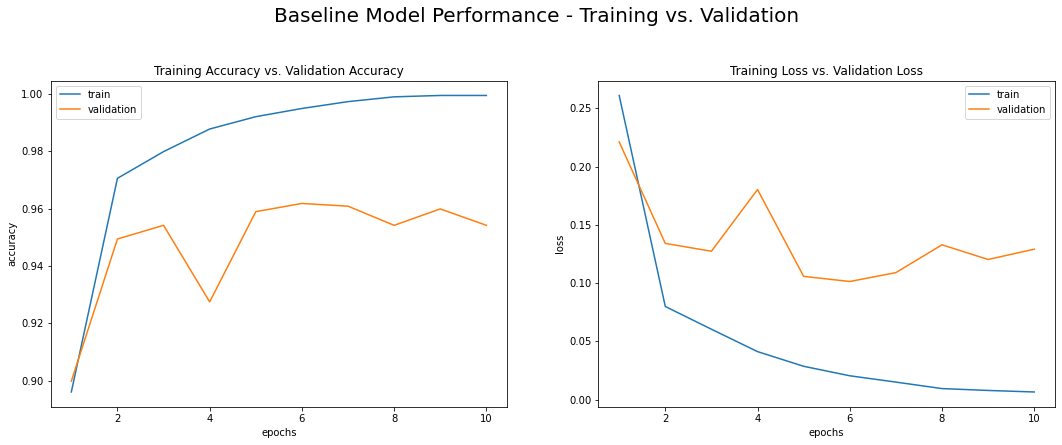

In [20]:
# view plot of the train/validate performance across epochs
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(18, 6))

fig.suptitle('Baseline Model Performance - Training vs. Validation', fontsize=20, y=1.05)

# visualize accuracy
axes[0].plot(epochs, baseline_train_acc, label='train')
axes[0].plot(epochs, baseline_val_acc, label = 'validation')
axes[0].set_title("Training Accuracy vs. Validation Accuracy")
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epochs')
axes[0].legend()

# visualize loss
axes[1].plot(epochs, baseline_train_loss, label='train')
axes[1].plot(epochs, baseline_val_loss, label = 'validation')
axes[1].set_title("Training Loss vs. Validation Loss")
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend();

> The accuracy & loss of the two data subsets is not so different; the training data is slightly more stable in both plots.

#### Model Evaluation
Assess the model's predictive ability:
* generate predictions from test set
* view classification report of test predictions
* view heatmap of true labels vs. predictions

In [21]:
# generate test predictions
baseline_test_preds = baseline_model.predict(test_generator) > 0.5

In [22]:
# view classification report
pd.DataFrame(classification_report(test_generator.classes, baseline_test_preds, output_dict=True)).transpose().style.set_caption('Baseline Classification Report')

,precision,recall,f1-score,support
0,0.274194,0.072650,0.114865,234.000000
1,0.613879,0.884615,0.724790,390.000000
accuracy,0.580128,0.580128,0.580128,0.580128
macro avg,0.444036,0.478632,0.419827,624.000000
weighted avg,0.486497,0.580128,0.496068,624.000000


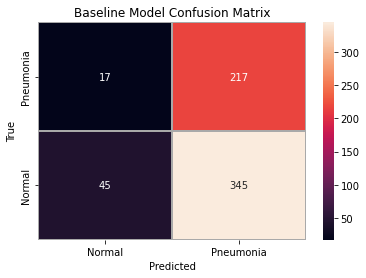

In [23]:
# confusion matrix
sns.heatmap(confusion_matrix(test_generator.classes, baseline_test_preds),
            xticklabels=['Normal', 'Pneumonia'],
            annot=True, fmt='.0f', linewidth = .8, linecolor= 'darkgray')

plt.yticks(ticks=[1.5, .5], labels=['Normal', 'Pneumonia'], verticalalignment='center')
plt.title('Baseline Model Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')

# save the plot
plt.savefig('images/baseline_conf_mat');

#### Interpretation
> A system using a classification model to sort patient chest X-rays, would be used to red-flag any scans that exhibit evidence of pneumonia, for further examination by a medical professional. As such, this report focuses primarily on **recall** (pneumonia) as the metric by which to assess a given model's performance. (This aims to avoid any false negatives, even at the risk of obtaining false positives, because the false positives will be identified through human intervention.)
  
The classification report reveals that the model's performance on the test set varies based on the metric considered. The recall score of .89 shows that the model finds nearly 90% of pneumonial scans. 

### Model 2
Let's aim for improved model performance by building a new model with more complexity than the first. In this version we include an additional convolutional layer (followed by a pooling layer) and 2 additional dense layers.The models structure is as follows:
* 2 convolutional layers, each followed by a pooling layer
* flattening layer
* 3 dense layers (including the final layer)

In [24]:
# build model_2
random.seed(583)
np.random.seed(583)
tf.random.set_seed(583)

model_2 = models.Sequential()

model_2.add(layers.Conv2D(16, kernel_size=(3, 3), input_shape=(150, 150, 3), activation='relu'))

model_2.add(layers.MaxPooling2D())

model_2.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))

model_2.add(layers.MaxPooling2D())

model_2.add(layers.Flatten())

model_2.add(layers.Dense(512, activation='relu'))

model_2.add(layers.Dense(256, activation='relu'))

model_2.add(layers.Dense(1, activation='sigmoid'))

In [25]:
# compile the model
model_2.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

In [26]:
%%time

# this cell takes a long time to run to fit the model, uncomment it to do so
# To avoid having to run this cell, use the saved model

# model_2.fit(train_generator, epochs=15, callbacks= early_stopping, validation_data=val_generator)

Wall time: 0 ns


In [27]:
# save the model
# the model is already saved, leave this line commented to avoid rewriting the file
# model_2.save('models/model_2.h5')

# save the model's history
# the model's history is already saved, leave these lines commented to avoid rewriting the file

# model_2_hist_dict = model_2.history.history

# with open('models/model_2_hist_dict.json', 'w') as f:
#     json.dump(model_2_hist_dict, f)

Load the model & its history from the models file:

In [28]:
# load the model & its history from the saved versions
model_2 = models.load_model('downloaded_models/models-and-histories/model_2.h5')

with open('downloaded_models/models-and-histories/model_2_hist_dict.json', 'r') as f:
    model_2_hist_dict = json.load(f)

#### Model Understanding
View the following to interpret the model:
* model summary
* plot training/validation progress across epochs

In [29]:
# view the model's summary
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               21234176  
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

To assess the model's training process, plot the accuracy & loss of each epoch:

In [30]:
# set variables for plot
model_2_train_loss = model_2_hist_dict['loss']
model_2_train_acc = model_2_hist_dict['acc']

model_2_val_loss = model_2_hist_dict['val_loss']
model_2_val_acc = model_2_hist_dict['val_acc']

epochs = range(1, len(model_2_train_acc)+1)

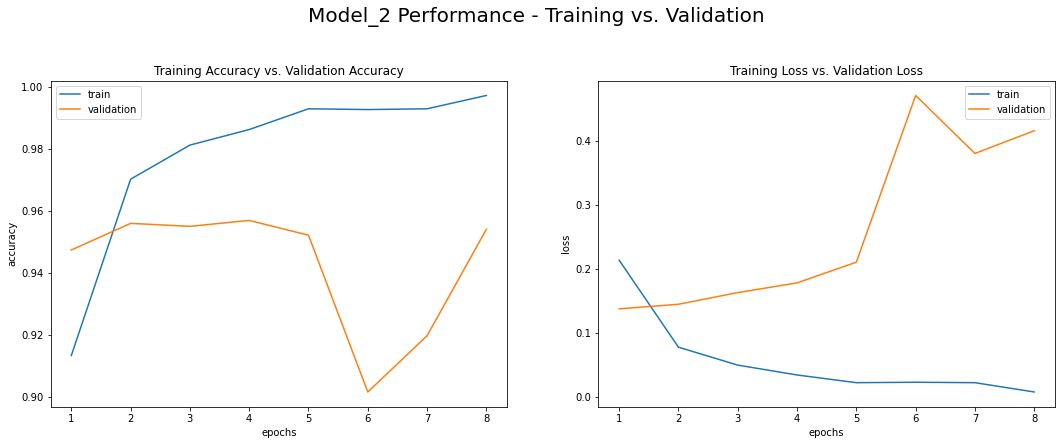

In [31]:
# plot the model's training performance
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(18, 6))

fig.suptitle('Model_2 Performance - Training vs. Validation', fontsize=20, y=1.05)

axes[0].plot(epochs, model_2_train_acc, label='train')
axes[0].plot(epochs, model_2_val_acc, label = 'validation')
axes[0].set_title("Training Accuracy vs. Validation Accuracy")
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epochs')
axes[0].legend()

axes[1].plot(epochs, model_2_train_loss, label='train')
axes[1].plot(epochs, model_2_val_loss, label = 'validation')
axes[1].set_title("Training Loss vs. Validation Loss")
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend();

> The accuracy & loss of the two data subsets follow nearly opposite patterns: both metrics improve for the train set as the number of epochs increases, but for the validation set there is no imroving trend, rather the accuracy is about stable or lower after the second epoch & the loss trends upward. There seems to be a bit of overfitting on the training data.

#### Model Evaluation
Assess the model's predictive ability:
* generate predictions from test set
* view classification report of test predictions
* view heatmap of true labels vs. predictions

In [32]:
# generate predictions for test set
model_2_test_preds = model_2.predict(test_generator) > 0.5

In [33]:
# view classification report of model's performance on test data
pd.DataFrame(classification_report(test_generator.classes, model_2_test_preds, output_dict=True)).transpose().style.set_caption('Model 2 Classification Report')

,precision,recall,f1-score,support
0,0.369231,0.102564,0.160535,234.000000
1,0.624329,0.894872,0.735511,390.000000
accuracy,0.597756,0.597756,0.597756,0.597756
macro avg,0.496780,0.498718,0.448023,624.000000
weighted avg,0.528667,0.597756,0.519895,624.000000


Text(0.5, 15.0, 'Predicted')

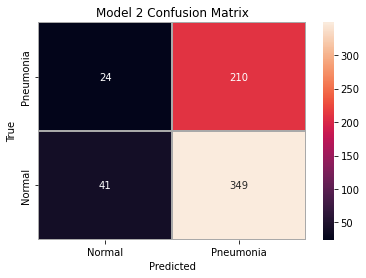

In [34]:
# confusion matrix
sns.heatmap(confusion_matrix(test_generator.classes, model_2_test_preds),
            xticklabels=['Normal', 'Pneumonia'],
            annot=True, fmt='.0f', linewidth = .8, linecolor= 'darkgray')

plt.yticks(ticks=[1.5, .5], labels=['Normal', 'Pneumonia'], verticalalignment='center')
plt.title('Model 2 Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')

# save the plot
# plt.savefig('images/model_2_conf_mat');

#### Interpretation
This model outperforms the baseline model across all metrics.
The recall score of .89 is just 1% higher than the previous model's .88. 

### Model 3
Again, let's aim for improved model performance by building another model with even more complexity than the previous one. In this version we include an additional convolutional layer (followed by a pooling layer) and 2 additional dense layers. The models structure is:
* 3 convolutional layers (each followed by a pooling layer)
* flattening layer
* 4 dense layers (including the final layer)

In [35]:
random.seed(583)
np.random.seed(583)
tf.random.set_seed(583)

model_3 = models.Sequential()

model_3.add(layers.Conv2D(16, kernel_size=(3, 3), input_shape=(150, 150, 3), activation='relu'))
model_3.add(layers.MaxPooling2D())

model_3.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D())

model_3.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D())

model_3.add(layers.Flatten())

model_3.add(layers.Dense(512, activation='relu'))

model_3.add(layers.Dense(256, activation='relu'))

model_3.add(layers.Dense(128, activation='relu'))

model_3.add(layers.Dense(1, activation='sigmoid'))

In [36]:
# compile the model
model_3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

In [37]:
%%time

# this cell takes a long time to run to fit the model, uncomment it to do so
# To avoid having to run this cell, use the saved model

# model_3.fit(train_generator, epochs=15, callbacks= early_stopping, validation_data=val_generator)

Wall time: 0 ns


In [38]:
# save the model
# the model is already saved, leave this line commented to avoid rewriting the file
# model_3.save('models/model_3.h5')

# save the model's history
# the model's history is already saved, leave these lines commented to avoid rewriting the file

# model_3_hist_dict = model_3.history.history

# with open('models/model_3_hist_dict.json', 'w') as f:
#     json.dump(model_3_hist_dict, f)

In [39]:
# load the model & its history from the saved versions
model_3 = models.load_model('downloaded_models/models-and-histories/model_3.h5')

with open('downloaded_models/models-and-histories/model_3_hist_dict.json', 'r') as f:
    model_3_hist_dict = json.load(f)

#### Model Understanding
View the following to interpret the model:
* model summary
* plot training/validation progress across epochs

In [40]:
# view the model's summary
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18496)            

To assess the model's training process, plot the accuracy & loss of each epoch:

In [41]:
# set variables for plot
model_3_train_loss = model_3_hist_dict['loss']
model_3_train_acc = model_3_hist_dict['acc']
model_3_val_loss = model_3_hist_dict['val_loss']
model_3_val_acc = model_3_hist_dict['val_acc']

epochs = range(1, len(model_3_hist_dict['loss'])+1)

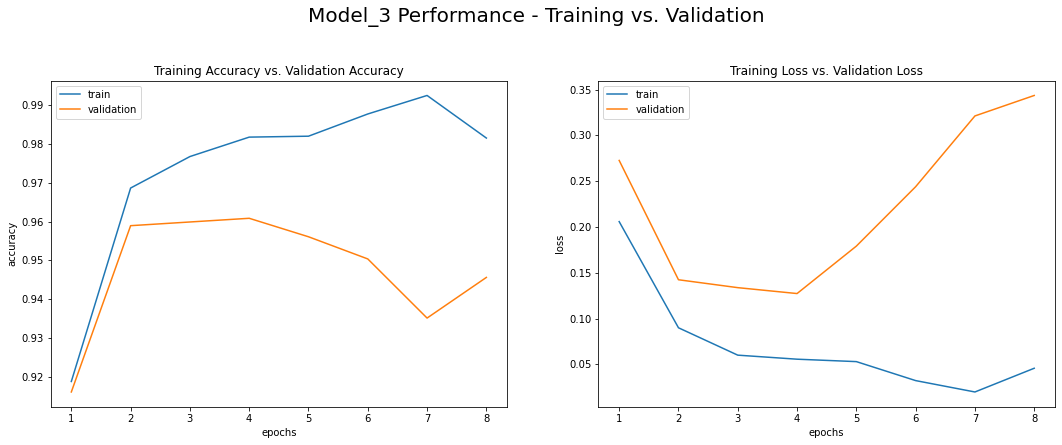

In [42]:
# plot the model's training performance
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(18, 6))

fig.suptitle('Model_3 Performance - Training vs. Validation', fontsize=20, y=1.05)

axes[0].plot(epochs, model_3_train_acc, label='train')
axes[0].plot(epochs, model_3_val_acc, label = 'validation')
axes[0].set_title("Training Accuracy vs. Validation Accuracy")
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epochs')
axes[0].legend()

axes[1].plot(epochs, model_3_train_loss, label='train')
axes[1].plot(epochs, model_3_val_loss, label = 'validation')
axes[1].set_title("Training Loss vs. Validation Loss")
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend();

> The model's accuracy on the validation set follows a similar pattern to its performance on the train set; improving with number of epochs. The loss of the validation set doesn't trend in either direction as the number of epochs increases, but loss for training set does decrease.

#### Model Evaluation
Assess the model's predictive ability:
* generate predictions from test set
* view classification report of test predictions
* view heatmap of true labels vs. predictions

In [43]:
# generate predictions for test set
model_3_test_preds = model_3.predict(test_generator) > 0.5

In [44]:
# view classification report of model's performance on test data
pd.DataFrame(classification_report(test_generator.classes, model_3_test_preds, output_dict=True)).transpose().style.set_caption('Model 3 Classification Report')

,precision,recall,f1-score,support
0,0.431034,0.106838,0.171233,234.000000
1,0.630742,0.915385,0.746862,390.000000
accuracy,0.612179,0.612179,0.612179,0.612179
macro avg,0.530888,0.511111,0.459047,624.000000
weighted avg,0.555852,0.612179,0.531001,624.000000


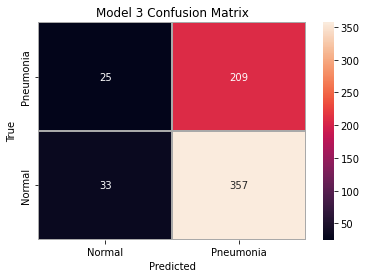

In [45]:
# confusion matrix
sns.heatmap(confusion_matrix(test_generator.classes, model_3_test_preds),
            xticklabels=['Normal', 'Pneumonia'],
            annot=True, fmt='.0f', linewidth = .8, linecolor= 'darkgray')

plt.yticks(ticks=[1.5, .5], labels=['Normal', 'Pneumonia'], verticalalignment='center')
plt.title('Model 3 Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted');

# save the plot
# plt.savefig('images/model_3_conf_mat');

#### Interpretation
With all of the metrics' scores higher, this more complex model performs better than the previous one. The recall of .91 is 2% higher than the earlier recall score of .89.
> This model, Model 3, is the best performing model.

#### Model 4
The iterative process followed above (beginning with a baseline & adding more complexity to succesive models) revealed that the highest scoring model (by recall) was Model 3. Let's revisit that model, but attempt to improve on it in 3 ways:
* adjust the training to acount for class imbalance with the class weights hyperparameter
* include dropout layers
* utilize regularization in the convolutional & all but the final dense layers (Level 2)

The layers of this model are:
* 3 convolutional layers, each followed by a pooling layer and a dropout layer
* flattening layer
* 3 dense layers, each followed by a dropout layer
* final dense layer

First, create a dictionary of classes & their associated weights for use in the training step:

In [46]:
# create a dictionary of classes as keys & their weights as values
c_weights = class_weight.compute_class_weight('balanced',
                                                 classes = [0, 1],
                                                 y = train_generator.classes)

c_weights_dict = dict(enumerate(c_weights))
c_weights_dict

{0: 2.4786729857819907, 1: 0.6263473053892216}

In [47]:
random.seed(583)
np.random.seed(583)
tf.random.set_seed(583)

model_4 = models.Sequential()

model_4.add(layers.Conv2D(16, kernel_regularizer=regularizers.l2(0.005), kernel_size=(3, 3), input_shape=(150, 150, 3), activation='relu'))
model_4.add(layers.MaxPooling2D())

model_4.add(layers.Dropout(0.3))

model_4.add(layers.Conv2D(32, kernel_regularizer=regularizers.l2(0.005), kernel_size=(3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D())

model_4.add(layers.Dropout(0.3))

model_4.add(layers.Conv2D(64, kernel_regularizer=regularizers.l2(0.005), kernel_size=(3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D())

model_4.add(layers.Dropout(0.3))

model_4.add(layers.Flatten())

model_4.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

model_4.add(layers.Dropout(0.3))

model_4.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

model_4.add(layers.Dropout(0.3))

model_4.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

model_4.add(layers.Dropout(0.3))

model_4.add(layers.Dense(1, activation='sigmoid'))

In [48]:
# compile the model
model_4.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

In [49]:
%%time

# this cell takes a long time to run to fit the model, uncomment it to do so
# To avoid having to run this cell, use the saved model

# model_4.fit(train_generator, epochs=15, callbacks=early_stopping, class_weight=c_weights_dict, validation_data=val_generator)

Wall time: 0 ns


In [50]:
# save the model
# the model is already saved, leave this line commented to avoid rewriting the file
# model_4.save('models/model_4.h5')

# save the model's history
# the model's history is already saved, leave these lines commented to avoid rewriting the file

# model_4_hist_dict = model_4.history.history

# with open('models/model_4_hist_dict.json', 'w') as f:
#     json.dump(model_4_hist_dict, f)

Load the model & its history from the models file:

In [51]:
# load the model & its history from the saved versions
model_4 = models.load_model('downloaded_models/models-and-histories/model_4.h5')

with open('downloaded_models/models-and-histories/model_4_hist_dict.json', 'r') as f:
    model_4_hist_dict = json.load(f)

#### Model Understanding
View the following to interpret the model:
* model summary
* plot training/validation progress across epochs

In [52]:
# view the model's summary
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)       

To assess the model's training process, plot the accuracy & loss of each epoch:

In [53]:
# set variables for plot
model_4_train_loss = model_4_hist_dict['loss']
model_4_train_acc = model_4_hist_dict['acc']

model_4_val_loss = model_4_hist_dict['val_loss']
model_4_val_acc = model_4_hist_dict['val_acc']

epochs = range(1, len(model_4_train_acc)+1)

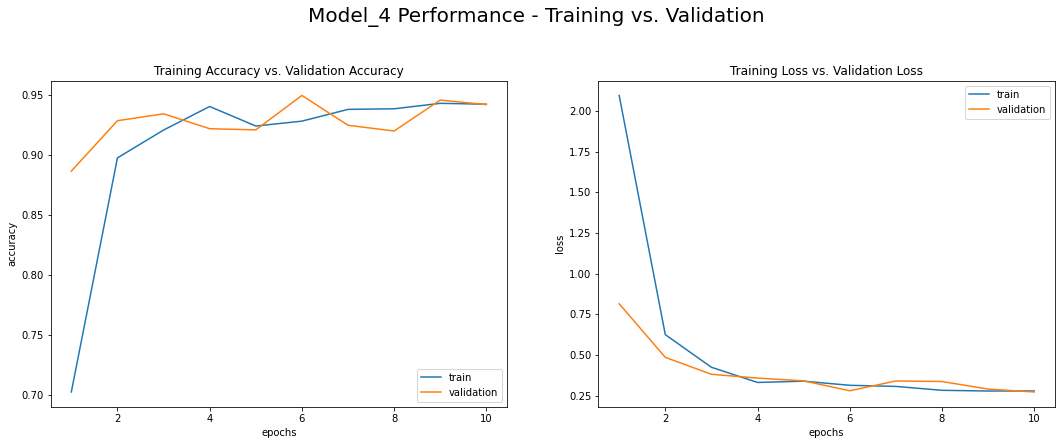

In [54]:
# plot the model's training performance
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(18, 6))

fig.suptitle('Model_4 Performance - Training vs. Validation', fontsize=20, y=1.05)

axes[0].plot(epochs, model_4_train_acc, label='train')
axes[0].plot(epochs, model_4_val_acc, label = 'validation')
axes[0].set_title("Training Accuracy vs. Validation Accuracy")
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epochs')
axes[0].legend()

axes[1].plot(epochs, model_4_train_loss, label='train')
axes[1].plot(epochs, model_4_val_loss, label = 'validation')
axes[1].set_title("Training Loss vs. Validation Loss")
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend();

> Th above plot shows that after the first epoch the validaton data tracks very closely with the training data. THis model performed really well (though it may prove overfit on the train/validate sets & not predict the test as well).

#### Model Evaluation
Assess the model's predictive ability:
* generate predictions from test set
* view classification report of test predictions
* view heatmap of true labels vs. predictions

In [55]:
# generate predictions for test set
model_4_test_preds = model_4.predict(test_generator) > 0.5

In [56]:
# view classification report of model's performance on test data
pd.DataFrame(classification_report(test_generator.classes, model_4_test_preds, output_dict=True)).transpose().style.set_caption('Model 4 Classification Report')

,precision,recall,f1-score,support
0,0.403846,0.179487,0.248521,234.000000
1,0.630769,0.841026,0.720879,390.000000
accuracy,0.592949,0.592949,0.592949,0.592949
macro avg,0.517308,0.510256,0.484700,624.000000
weighted avg,0.545673,0.592949,0.543745,624.000000


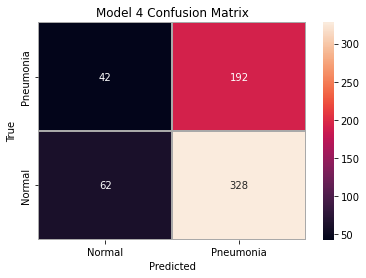

In [57]:
# confusion matrix
sns.heatmap(confusion_matrix(test_generator.classes, model_4_test_preds),
            xticklabels=['Normal', 'Pneumonia'],
            annot=True, fmt='.0f', linewidth = .8, linecolor= 'darkgray')

plt.yticks(ticks=[1.5, .5], labels=['Normal', 'Pneumonia'], verticalalignment='center')
plt.title('Model 4 Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted');

# save the plot
# plt.savefig('images/model_4_conf_mat');

#### Interpretation
With a recall score of .82, this model undeperforms the earlier ones. Although it does do a better job with normal scans, when considering how it classifies pneumonial scans, it's not nearly as good.
> Model 3 is the most performant model.

### Modeling Summary
The iterative process followed in this section results in the following conclusion:
A model with the following structure provided the best results:
* 3 convolutional layers (each followed by a pooling layer)
* flattening layer
* 4 dense layers (including the final layer)

> Such a model was able to accurately classify 91% of the scans with pneumonia.

Adding dropout layers, using regularization, & adding model weights worsened the model's ability to identify which scans exhibit signs of pneumonia.

***
## Limitations/Next Steps
Several points should be taken into account when considering the findings of this report:
* The performance metrics of the best model vary drastically (e.g. Recall for negative predictions is 10%). In this process, the model's recall for identifying positive cases of pneumonia is the metric by which performance is assessed. Certain use cases of may indicate a different metric be used. (e.g. If a given treatment is only warranted in the absence of pneumonia, a metric that is focused on negative predictions makes more sense.)
* The performance of CNN models is greatly improved with the use of more data (images) in the training process. Although the available data used for this project is limited, an attempt to generate more training data by creating augmented images from the given image collection may provide sufficient to achieve improved results.
* In an effort to reduce training times, only a limited number of models were attempted. Running additional models with greater levels of complexity & a greater number of hyperparameters adjusted, may have eventually yielded a more precise model.